# Commodity price forecasting using RNN

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# deep learning libraries
from keras.models import Input, Model
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, GRU
from keras.layers import Conv1D, MaxPooling1D
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import initializers

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import and basic analysis

In [3]:
DATADIR = 'data/'
MODELDIR = '../checkpoints/commodity/nn/'

path = os.path.join(DATADIR, 'gold-silver.csv')
data = pd.read_csv(path, header=0, index_col=[0], infer_datetime_format=True, sep=';')

data.head()

,gold,silver
Date,,
1993/11/01,369.25,4.25
1993/12/01,376.30,4.62
1994/01/01,394.00,5.24
1994/02/01,384.50,5.31
1994/03/01,378.75,5.32


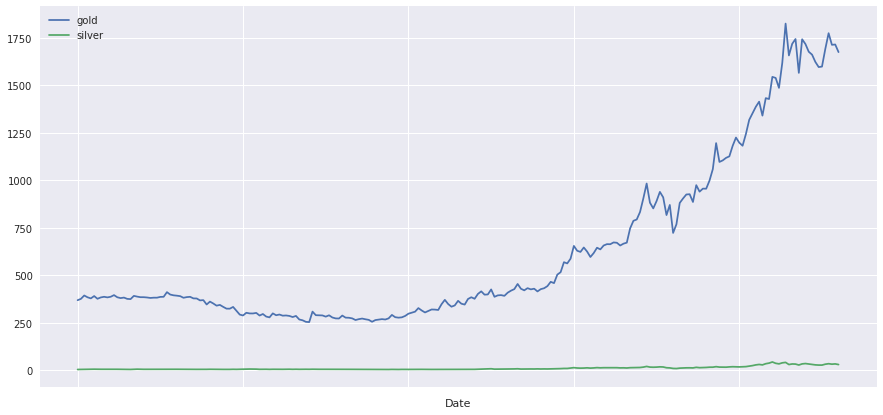

In [4]:
data[['gold', 'silver']].plot();

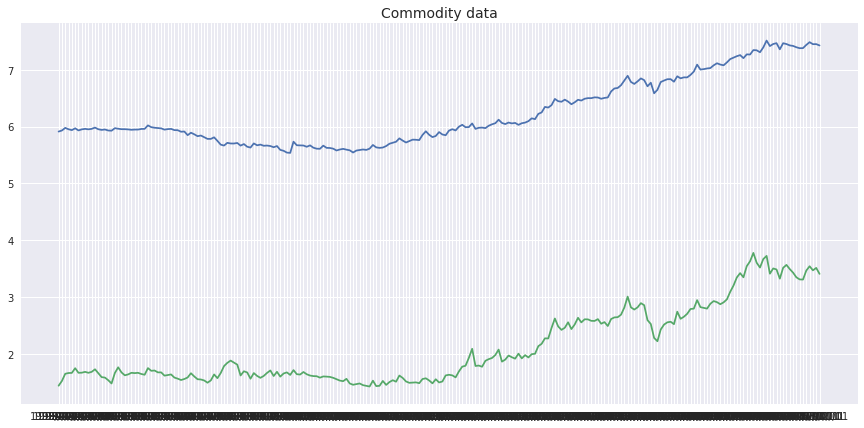

In [5]:
plt.plot(np.log(data.gold), label='log(gold)')
plt.plot(np.log(data.silver), label='log(silver)')
plt.title('Commodity data', fontsize='14')
plt.show()

## 2. Data preparation

In [6]:
# function to prepare x and y variable
# for the univariate series
def prepare_data(df, steps=1):
    temp = df.shift(-steps).copy()
    y = temp[:-steps].copy()
    X = df[:-steps].copy()
    return X, y

In [7]:
gold_X, gold_y = prepare_data(np.log(data[['gold']]), steps=1)
silver_X, silver_y = prepare_data(np.log(data[['silver']]), steps=1)

len(gold_X), len(gold_y), len(silver_X), len(silver_y)

(230, 230, 230, 230)

In [8]:
X = pd.concat([gold_X, silver_X], axis=1)
y = pd.concat([gold_y, silver_y], axis=1)

In [9]:
X.head()

,gold,silver
Date,,
1993/11/01,5.911474,1.446919
1993/12/01,5.930387,1.530395
1994/01/01,5.976351,1.656321
1994/02/01,5.951944,1.669592
1994/03/01,5.936876,1.671473


In [10]:
y.head()

,gold,silver
Date,,
1993/11/01,5.930387,1.530395
1993/12/01,5.976351,1.656321
1994/01/01,5.951944,1.669592
1994/02/01,5.936876,1.671473
1994/03/01,5.968708,1.754404


In [11]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, 
                                                    random_state=seed, shuffle=False)

print('Training and test data shape:')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Training and test data shape:


((218, 2), (218, 2), (12, 2), (12, 2))

In [12]:
timesteps = 1
features = X_train.shape[1]
xavier = initializers.glorot_normal()

X_train = np.reshape(X_train.values, (X_train.shape[0], timesteps, features))
X_test = np.reshape(X_test.values, (X_test.shape[0], timesteps, features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((218, 1, 2), (12, 1, 2), (218, 2), (12, 2))

## 3. Model building

In [13]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    y_train_inv, y_test_inv = np.exp(y_train), np.exp(y_test)
    y_train_pred_inv, y_test_pred_inv = np.exp(y_train_pred), np.exp(y_test_pred)
    
    # MAE and NRMSE calculation for gold
    y_train_gold = y_train_inv.values[:, 0]
    y_train_pred_gold = y_train_pred_inv[:, 0]  
    y_test_gold = y_test_inv.values[:, 0]
    y_test_pred_gold = y_test_pred_inv[:, 0]
    
    train_rmse_g = np.sqrt(mean_squared_error(y_train_gold, y_train_pred_gold))
    train_mae_g = np.round(mean_absolute_error(y_train_gold, y_train_pred_gold), 3)
    train_nrmse_g = np.round(train_rmse_g/np.std(y_train_gold), 3)

    test_rmse_g = np.sqrt(mean_squared_error(y_test_gold, y_test_pred_gold))
    test_mae_g = np.round(mean_absolute_error(y_test_gold, y_test_pred_gold), 3)
    test_nrmse_g = np.round(test_rmse_g/np.std(y_test_gold), 3)
    
    print('Training and test result for gold:')
    print(f'Training MAE: {train_mae_g}')
    print(f'Trainig NRMSE: {train_nrmse_g}')
    print(f'Test MAE: {test_mae_g}')
    print(f'Test NRMSE: {test_nrmse_g}')
    print()
    
    
    # MAE and NRMSE calculation for silver
    y_train_silver = y_train_inv.values[:, 1]
    y_train_pred_silver = y_train_pred_inv[:, 1]
    y_test_silver = y_test_inv.values[:, 1]
    y_test_pred_silver = y_test_pred_inv[:, 1] 
    
    train_rmse_s = np.sqrt(mean_squared_error(y_train_silver, y_train_pred_silver))
    train_mae_s = np.round(mean_absolute_error(y_train_silver, y_train_pred_silver), 3)
    train_nrmse_s = np.round(train_rmse_s/np.std(y_train_silver), 3)

    test_rmse_s = np.sqrt(mean_squared_error(y_test_silver, y_test_pred_silver))
    test_mae_s = np.round(mean_absolute_error(y_test_silver, y_test_pred_silver), 3)
    test_nrmse_s = np.round(test_rmse_s/np.std(y_test_silver), 3)

    print('Training and test result for silver:')
    print(f'Training MAE: {train_mae_s}')
    print(f'Trainig NRMSE: {train_nrmse_s}')
    print(f'Test MAE: {test_mae_s}')
    print(f'Test NRMSE: {test_nrmse_s}')
    
    return y_train_pred_inv, y_test_pred_inv

In [14]:
def model_training(X_train, X_test, y_train, model, batch=4, name='m'):
    start = time.time()
    loss = losses.mean_squared_error
    opt = optimizers.Adam()
    metric = [metrics.mean_absolute_error]
    model.compile(loss=loss, optimizer=opt, metrics=metric)

    callbacks_list = [callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)]

    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=batch, 
                        verbose=0,
                        shuffle=False,
                        callbacks=callbacks_list
                       )

    # save model weights and 
    if os.path.exists(MODELDIR):
        pass
    else:
        os.makedirs(MODELDIR)
    m_name = name + str('.h5')
    w_name = name + str('_w.h5')
    model.save(os.path.join(MODELDIR, m_name))
    model.save_weights(os.path.join(MODELDIR, w_name))

    # prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    end = time.time()
    time_taken = np.round((end-start), 3)
    print(f'Time taken to complete the process: {time_taken} seconds')
    
    return y_train_pred, y_test_pred, history

### RNN - v1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 3)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8         
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 6.019 seconds
Training and test result for gold:
Training MAE: 468.306
Trainig NRMSE: 1.623
Test MAE: 1589.648
Test NRMSE: 29.911

Training and test result for silver:
Training MAE: 5.205
Trainig NRMSE: 1.027
Test MAE: 23.784
Test NRMSE: 9.179


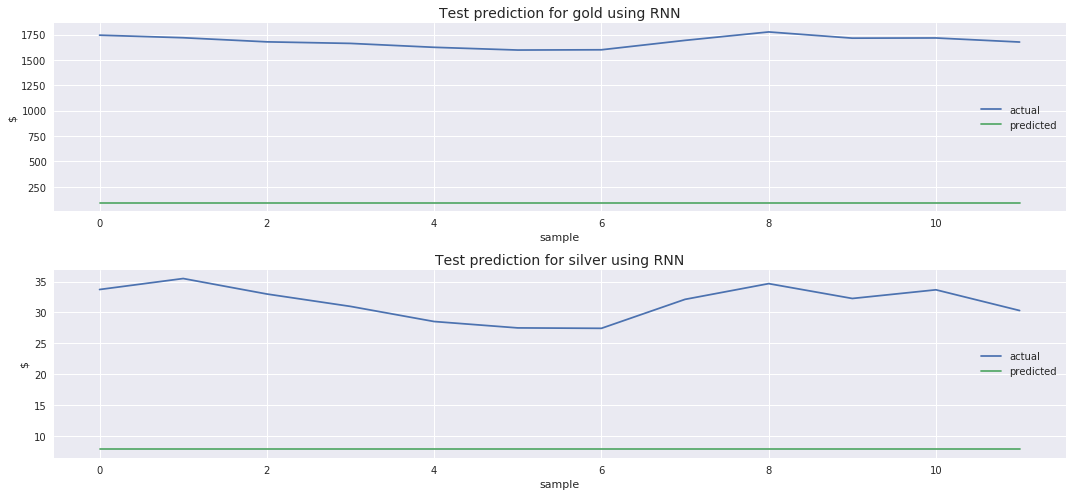

In [15]:
model = Sequential()
model.add(SimpleRNN(3, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='rnn-v1')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### RNN - v2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 1, 3)              18        
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 3)                 21        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8         
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 8.813 seconds
Training and test result for gold:
Training MAE: 73.49
Trainig NRMSE: 0.409
Test MAE: 444.285
Test NRMSE: 8.681

Training and test result for silver:
Training MAE: 3.106
Trainig NRMSE: 0.645
Test MAE: 14.209
Test NRMSE: 5.53


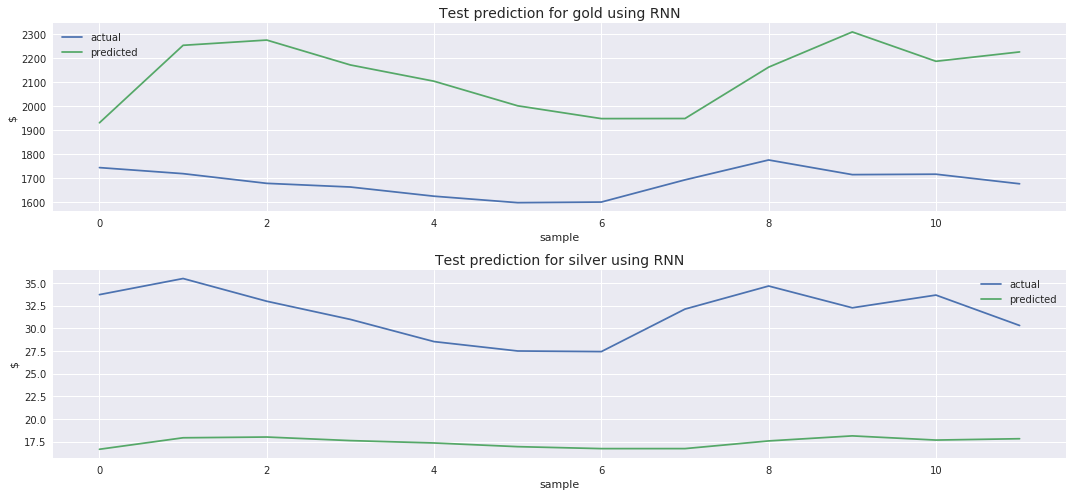

In [16]:
model = Sequential()

model.add(SimpleRNN(3, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu', return_sequences=True))
model.add(SimpleRNN(3, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='rnn-v2')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### RNN - v3 (Final Model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 1, 5)              40        
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 12        
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 8.828 seconds
Training and test result for gold:
Training MAE: 53.662
Trainig NRMSE: 0.168
Test MAE: 61.182
Test NRMSE: 1.291

Training and test result for silver:
Training MAE: 0.895
Trainig NRMSE: 0.19
Test MAE: 2.585
Test NRMSE: 1.108


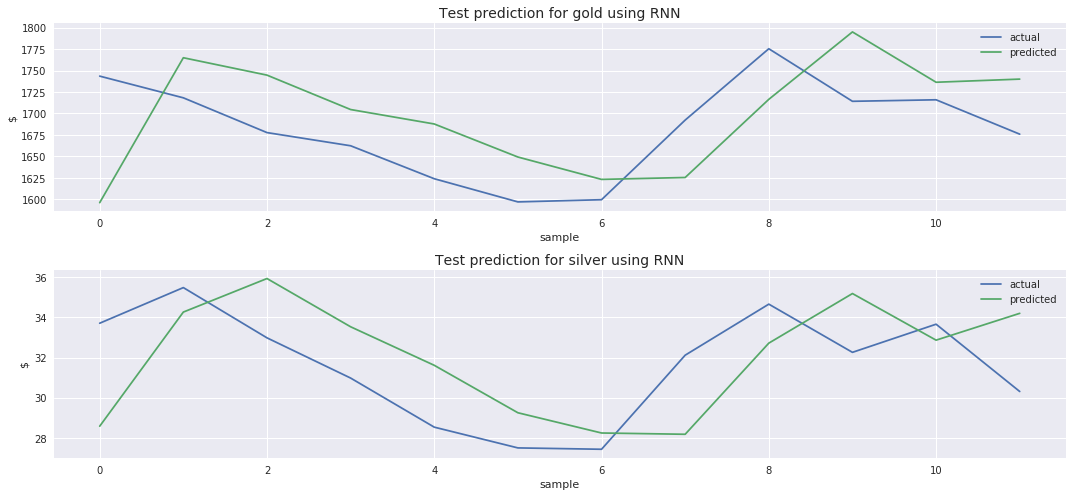

In [17]:
model = Sequential()

model.add(SimpleRNN(5, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu', return_sequences=True))
model.add(SimpleRNN(5, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='rnn-v3')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

# RNN - v4

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 5)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 12        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 6.936 seconds
Training and test result for gold:
Training MAE: 28.15
Trainig NRMSE: 0.117
Test MAE: 72.639
Test NRMSE: 1.476

Training and test result for silver:
Training MAE: 0.836
Trainig NRMSE: 0.194
Test MAE: 2.568
Test NRMSE: 1.101


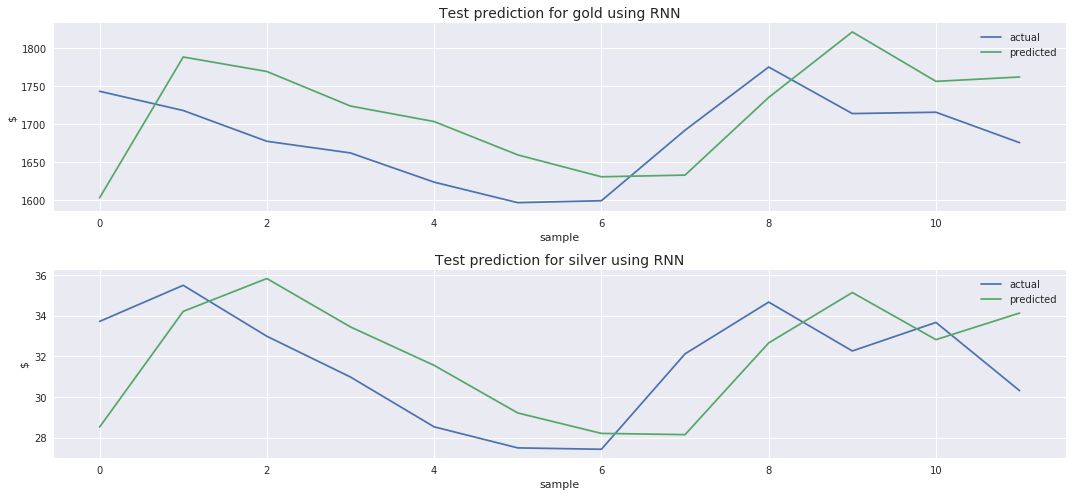

In [18]:
model = Sequential()

model.add(SimpleRNN(5, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='rnn-v4')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### RNN - v5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 10)                130       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 6.672 seconds
Training and test result for gold:
Training MAE: 28.135
Trainig NRMSE: 0.122
Test MAE: 66.541
Test NRMSE: 1.459

Training and test result for silver:
Training MAE: 1.838
Trainig NRMSE: 0.395
Test MAE: 7.547
Test NRMSE: 3.035


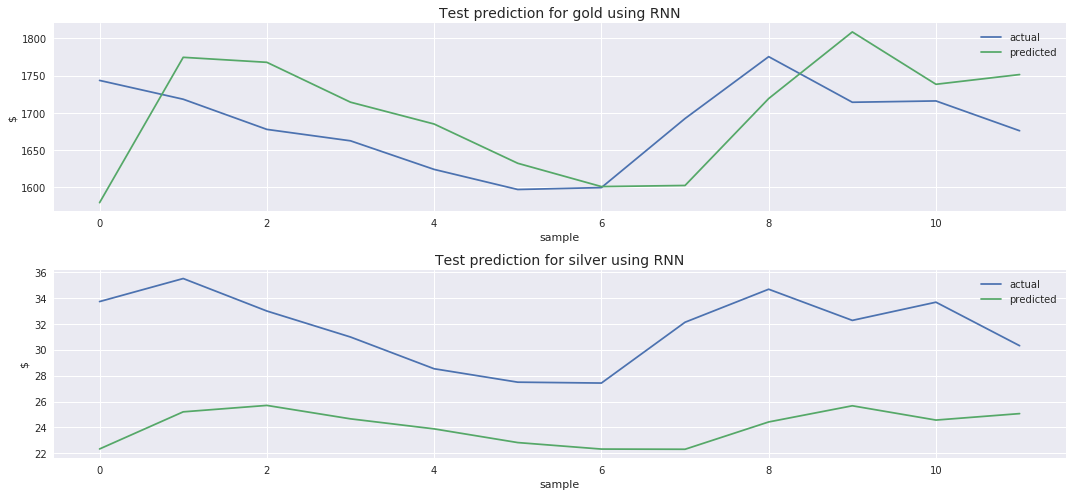

In [19]:
model = Sequential()

model.add(SimpleRNN(10, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='rnn-v5')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

### RNN - v6

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 7)                 70        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 16        
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 6.726 seconds
Training and test result for gold:
Training MAE: 31.913
Trainig NRMSE: 0.166
Test MAE: 86.22
Test NRMSE: 1.804

Training and test result for silver:
Training MAE: 0.795
Trainig NRMSE: 0.185
Test MAE: 2.561
Test NRMSE: 1.124


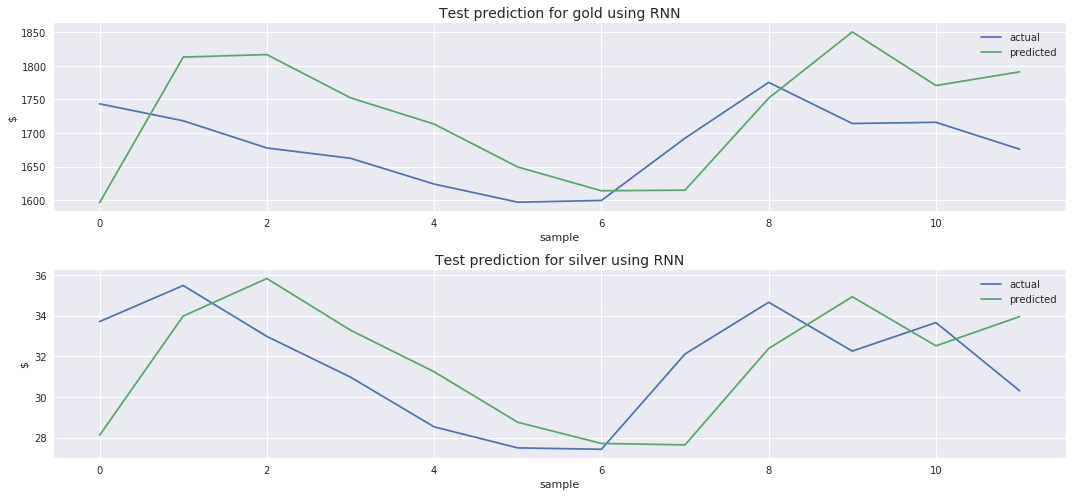

In [20]:
model = Sequential()

model.add(SimpleRNN(7, input_shape = (timesteps, features), kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

# training
y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='rnn-v6')

# evaluation
y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

# plotting
plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using RNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using RNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()